<a href="https://colab.research.google.com/github/dbenayoun/IASD/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An autoencoder (**AE**) is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. This is an example of unsupervised learning. Autoencoder can be used to learn representation (the by product of the encoder), and to detect anomalies.  

An autoencoder consists in two blocks:
- the encoder projects the input in a latent space of "reduced" dimension (in comparison with the input).
- the decoder maps some latent representation back in the input space.

Basically, if you consider an input $\mathbf{x}$ :
$$\mathbf{z} = encoder(\mathbf{x})$$
$$\mathbf{\tilde{x}} = decoder(\mathbf{z})$$

The goal is to train the AE, the goal is to minimize the reconstruction error. This error can be defined as the mean square error for instance :
$$\min||\mathbf{\tilde{x}}-\mathbf{x}||^2$$

For this lab session, you can work with the MNIST dataset and we will train 4 different models:
- A linear Endoder/Decoder
- A non-linear Fully Connected Encoder/Decoder
- A Convolutional Encoder/Decoder
- A U-Net Encoder/Decoder

More details and constraints will be given through the practical session.
Program:
1. Import Data and visualize the images
2. Build a train/test wrapper
3. Train a linear model and understand how the latent dimension affects the reconstruction
4. Use the model to denoise
5. Use the model for anomaly detection
6. Train and use a Fully Connected model for denoising and anomaly detection
7. Train and use a Convolutional model for denoising and anomaly detection


First, we import the package required for the TP.

In [1]:
import numpy as np # Library for numerical calculations
import matplotlib.pyplot as plt # Library for plotting

import math # Library for mathematical functions

import torch # Library for tensor computations - for Deep Learning
import torch.nn as nn # Neural Network module
import torch.optim as optim # Optimization module
from torchvision import datasets, transforms # Computer Vision module

%matplotlib inline
%config InlineBackend.figure_formats=['retina']
%config InlineBackend.figure_format = 'retina'

First we need to check if there are gpu on this computer:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Device for tensor computations

And functions that will be useful to:
- Plot the reconstruction
- Plot the data in the latent space
- Print the number of parameters

In [3]:
def plot_result(model):
    '''plot_result
    Plot the first 5 images of the test set and their reconstructions
    Input:
        - model: the trained model
    Output:
        - None
    '''
    first_outputs = model(first_batch_images.to(device))
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(first_batch_images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title('Input')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(2, 5, i+6)
        plt.imshow(first_outputs[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        plt.title('Output')
        plt.xticks([])
        plt.yticks([])
    plt.show()

def plotLatentScatter(encoder, classes=None):
    '''plotLatentScatter
    Plot the test dataset in the latent space of the encoder
    Input:
        - encoder: the encoder model
        - classes: the classes to plot
    Output:
        - None
    '''
    latent_numpy = []
    labels_numpy = []
    for images, labels in test_loader:
        x = images.to(device)
        latent_numpy.append(encoder(x).cpu().detach().numpy())
        labels_numpy.append(labels.numpy())
    if classes is None :
        classes = range(10)
    latent_numpy = np.concatenate(latent_numpy)
    labels_numpy = np.concatenate(labels_numpy)
    for c in classes:
        plt.scatter(latent_numpy[labels_numpy==c,0],latent_numpy[labels_numpy==c,1],marker="o",alpha=0.1,label=str(c))
    plt.legend()
    plt.show()

def print_nparameters(model):
    '''print_nparameters
    Print the number of parameters of the model
    Input:
        - model: the model
    Output:
        - None
    '''
    nparameters = 0
    for parameter in model.parameters():
        nparameters += parameter.numel()
    print('Number of parameters:', nparameters)

# 1 Import Data and visualize the images

In [4]:
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

print('Train dataset:', train_dataset, "\n")
print('Test dataset:', test_dataset)

100%|██████████| 9912422/9912422 [00:00<00:00, 133449671.14it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 32872644.19it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 41505724.81it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12103258.43it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Train dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor() 

Test dataset: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


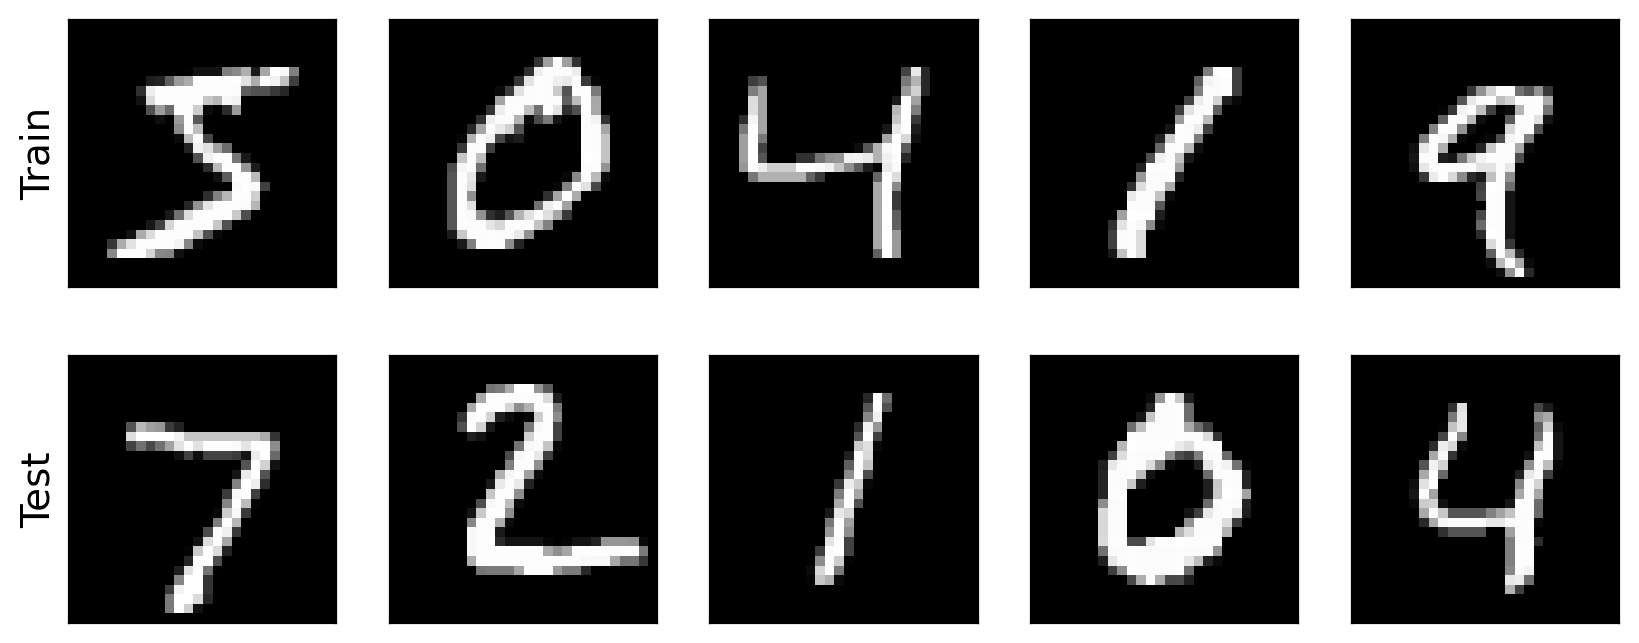

In [5]:
samples_train = train_dataset.data[:5]
samples_test = test_dataset.data[:5]
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    if i == 0:
        plt.ylabel('Train', fontsize=14)
    plt.imshow(samples_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2, 5, i+6)
    if i == 0:
        plt.ylabel('Test', fontsize=14)
    plt.imshow(samples_test[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])


We need to build the dataloader: a function that cut the dataset in batches.

In [6]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

In [7]:
first_batch_images, first_batch_labels = next(iter(train_loader))
print('First batch:', first_batch_images.shape, first_batch_labels.shape)

First batch: torch.Size([100, 1, 28, 28]) torch.Size([100])


In [23]:
image_dim = first_batch_images.shape[2]
print(image_dim)

28


# 2 Wrapper for training and Evaluation

The goal of this section is to automatize the process of training and testing the model.

To do so, we will define a function that will take as input the model, the loss function, the optimizer, the number of epochs, and the train and test loaders. The function will return the loss of the model during the training and testing phases.

TODO:
- Complete the AE_train function

In [74]:
def AE_eval(model, criterion):
    '''AE_eval
    Evaluate the model on the test set
    Input:
        - model: the trained model
        - criterion: the loss function
    Output:
        - test_loss: the average loss on the test set
    '''
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, images).item()
    return test_loss/len(test_loader)

def AE_train(model, criterion, optimizer, epochs=30, plot=True,verbose=False, freq=10):
    '''AE_train
    Train the model
    Input:
        - model: the model to train
        - criterion: the loss function
        - optimizer: the optimization algorithm
        - epochs: the number of epochs
        - plot: if True, plot the train and test losses
        - verbose: if True, print the losses
        - freq: frequency of printing the losses
    Output:
        - train_losses: the train losses
        - test_losses: the test losses
    '''
    if verbose:
        print('Start training...')
    train_losses=[]
    test_losses=[AE_eval(model, criterion)] # Evaluate the model on the test set
    f = 0
    if verbose:
      print("Test Losses:", test_losses[0])
    for e in range(epochs):
      if verbose:
        print("Epoch:", e)
      model.train() # - Set the model to train mode
      for batch_idx, (images, labels) in enumerate(train_loader):
        f = f + 1
        # Complete code here
        # Your code must include the following lines:
        model.train() # - Set the model to train mode
        images = images.to(device)# - Move the images to the device
        optimizer.zero_grad()# - Reset the optimizer
        output = model(images)# - Forward pass
        loss = criterion(output, images)# - Compute the loss
        loss.backward()# - Backward pass
        optimizer.step()# - Update the weights

        train_losses.append(loss.item()) #save loss

        if verbose and f%freq==0:
          print("Loss:", loss.item())# - Print the losses if verbose is True
      test_losses.append(AE_eval(model, criterion))# - Evaluate the model at the end of each epoch



    if plot:
        plt.plot(train_losses, label='Train loss')
        plt.plot([e*batch_idx for e in range(e+2)], test_losses, label='Test loss', marker='o', linewidth=0.0)
        plt.legend()
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.show()
    return train_losses, test_losses



# 3 Linear Auto-encoder

The basic idea is to have a linear transformation for both the encoder and decoder.
For the output activation, we can use the sigmoid, since we know that the images are in greyscale, and the pixel values are between $0$ and $1$.

The only hyperparameter we have is the dimension of the latent space: $h_{\mathrm{dim}} < 784$.

## 3.1 First model

**TODO**:
- Write a class for the encoder
- Test it on some images as sanity-check using the *plot_result* function



In [26]:
### Write the class
class AElin(nn.Module):
    '''AElin
    Autoencoder with linear layers
    Parameters:
        - hdim: the dimension of the hidden layer
    '''
    def __init__(self,hdim = 2):
        super().__init__()
        # Use the function nn.Sequential to define the encoder and decoder
        self.encoder = nn.Sequential(nn.Linear(28*28, hdim)) # Complete code here
        self.decoder = nn.Sequential(nn.Linear(hdim, 28*28), nn.Sigmoid()) # Complete code here

    def encoder_function(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.reshape(x.size(0), 1, 28, 28)
        return decoded



Number of parameters: 3922


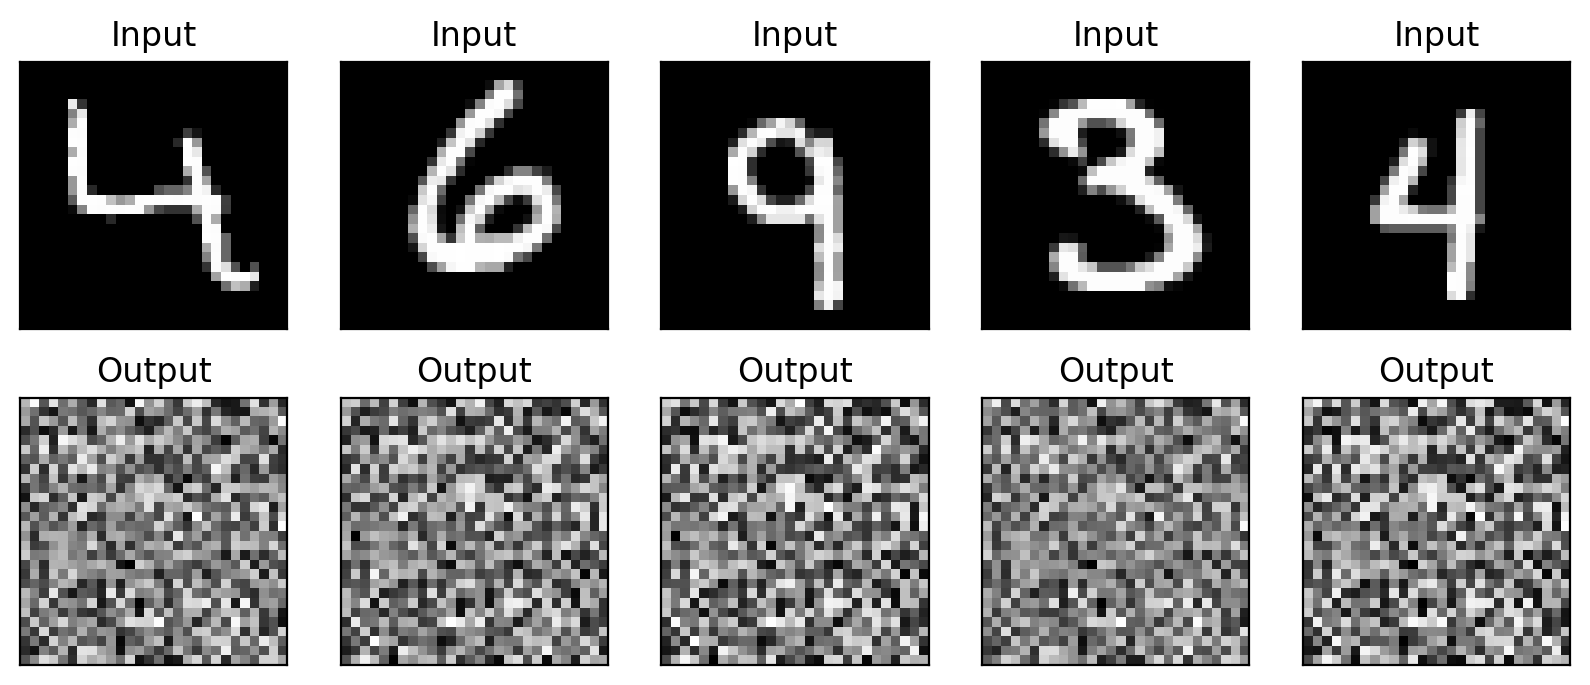

In [29]:
# Define the model and test it
AE = AElin().to(device)
print_nparameters(AE)
plot_result(AE)

**TODO**
- Train your model and plot the loss during training for 5 epochs.
- Observe the result



Number of parameters: 32164
Start training...
Test Losses: 0.23284553855657578
Epoch: 0
Loss: 0.06522661447525024
Loss: 0.056018173694610596
Loss: 0.04646803066134453
Loss: 0.042879048734903336
Loss: 0.03818722441792488
Loss: 0.034906063228845596
Epoch: 1
Loss: 0.03647034242749214
Loss: 0.030998878180980682
Loss: 0.02787611447274685
Loss: 0.026035601273179054
Loss: 0.026136640459299088
Loss: 0.023966185748577118
Epoch: 2
Loss: 0.024045493453741074
Loss: 0.02250070311129093
Loss: 0.023499874398112297
Loss: 0.022426700219511986
Loss: 0.021940700709819794
Loss: 0.01958848349750042


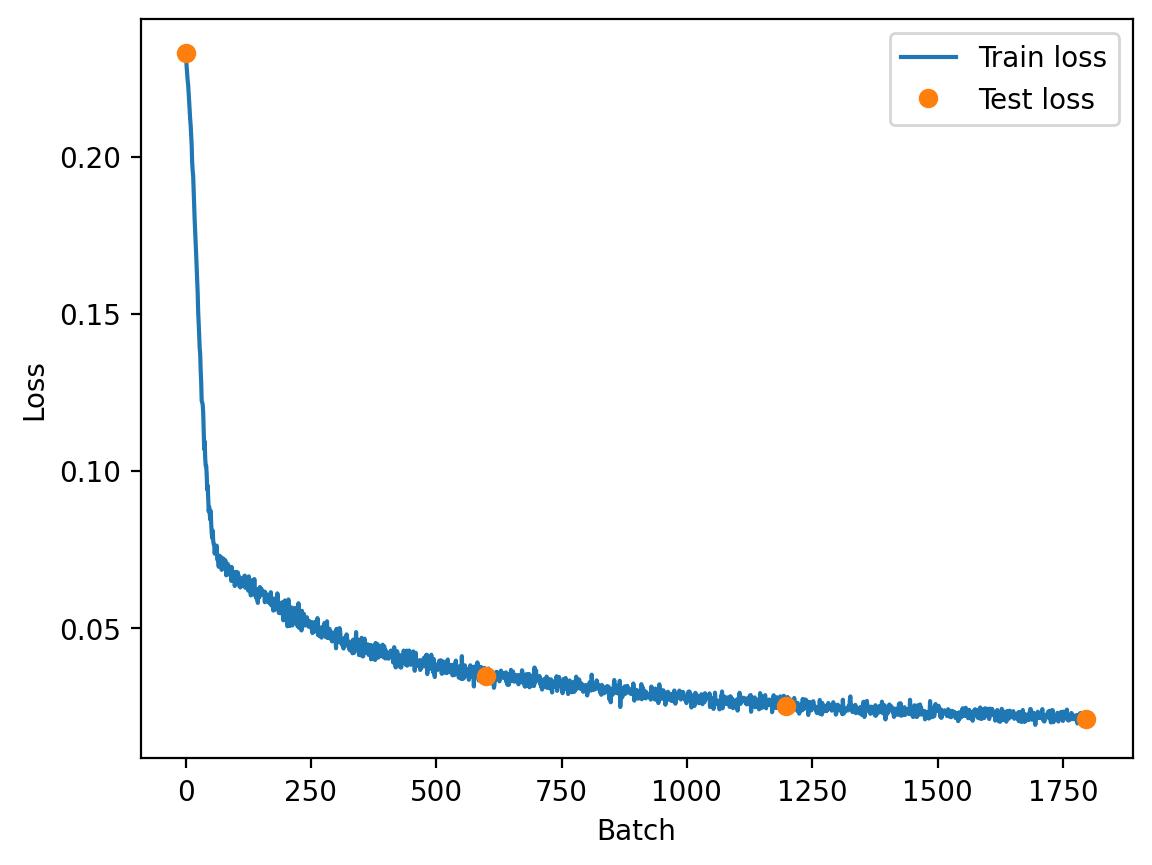

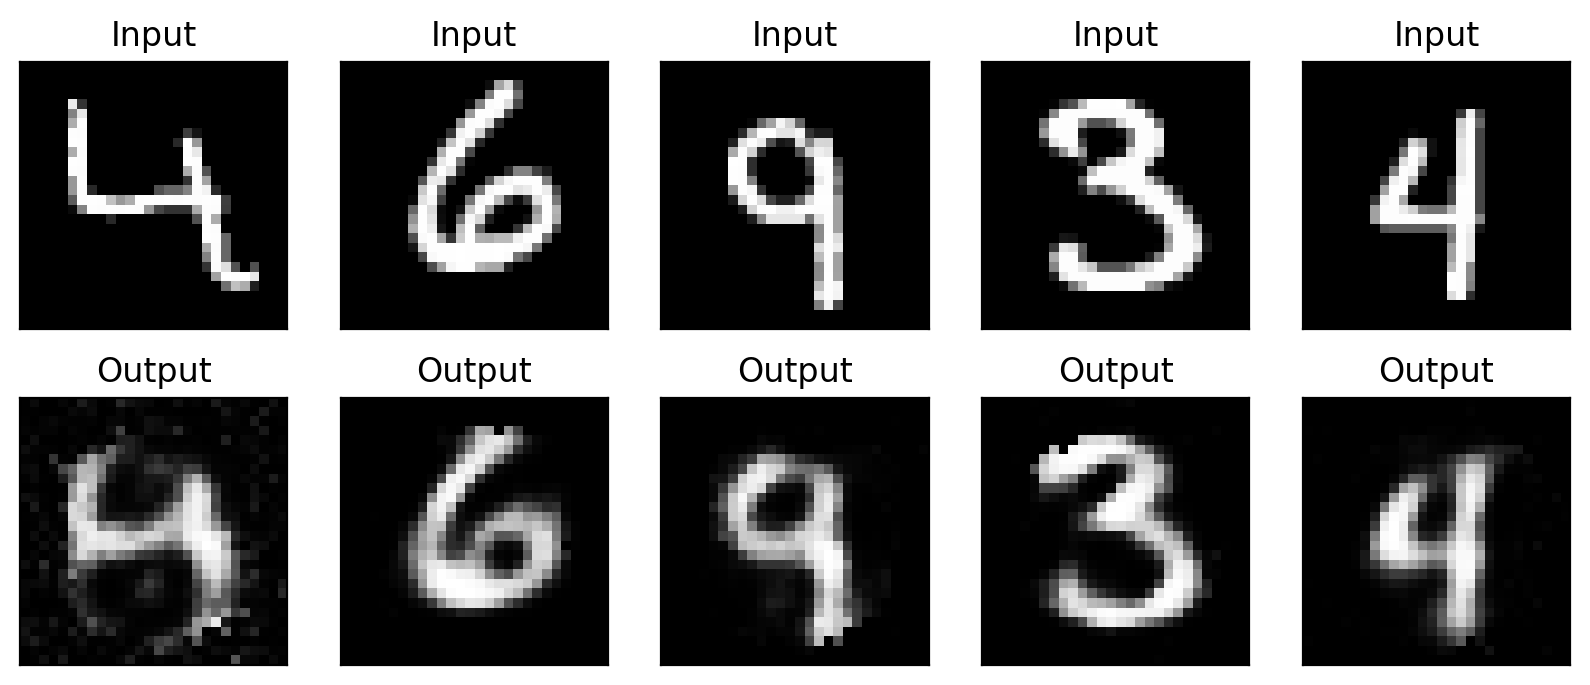

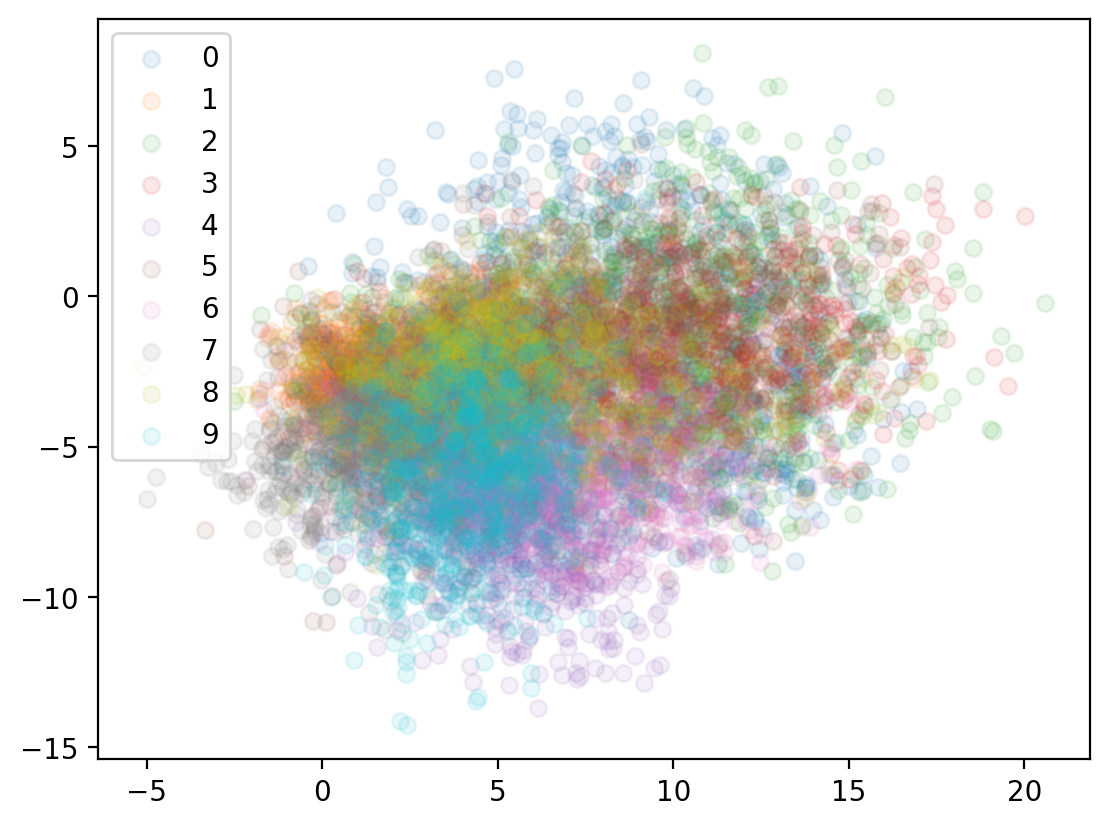

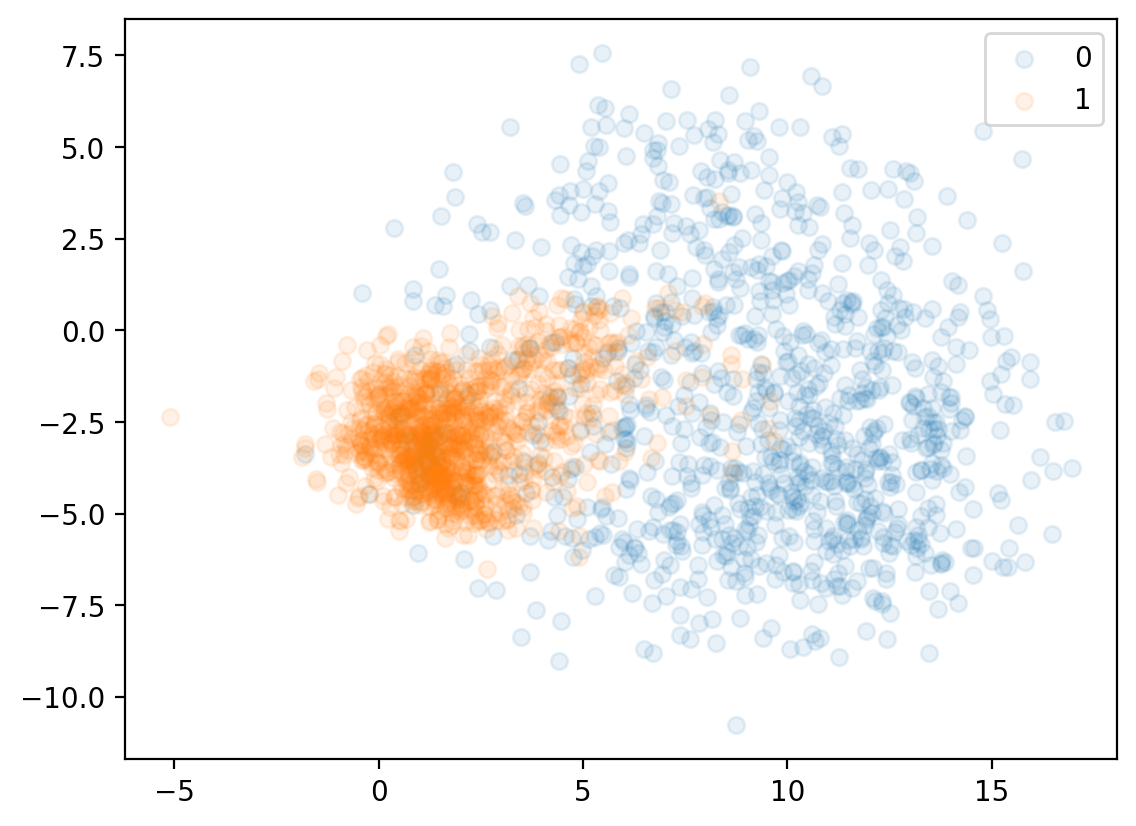

In [68]:
# Model Initialization
AE = AElin(hdim=20).to(device)
print_nparameters(AE)

# Validation using MSE Loss function
lossAE = nn.MSELoss() # Complete code here

# Using an Adam Optimizer
optimizer =  torch.optim.Adam(AE.parameters(), lr=0.001) # Complete code here

#def AE_train(model, criterion, optimizer, epochs=30, plot = True,verbose=False, freq=10):
AE_train(AE, lossAE, optimizer, epochs=2, plot=True, verbose=True, freq=100) # Complete code here


plot_result(AE)
plotLatentScatter(AE.encoder_function, classes=[0,1,2,3,4,5,6,7,8,9])
plotLatentScatter(AE.encoder_function, classes=[0,1])

## 3.2 Try different hyperpameters

**TODO**
- Try different latent dimension: 2, 10, 20 50, 100
- Try different learning rates: 1e-1, 1e-2, 1e-3, 1e-4, 1e-5 with $h_{dim}=20$

For each try, plot the reconstructions result and the losses.

Hdim: 2


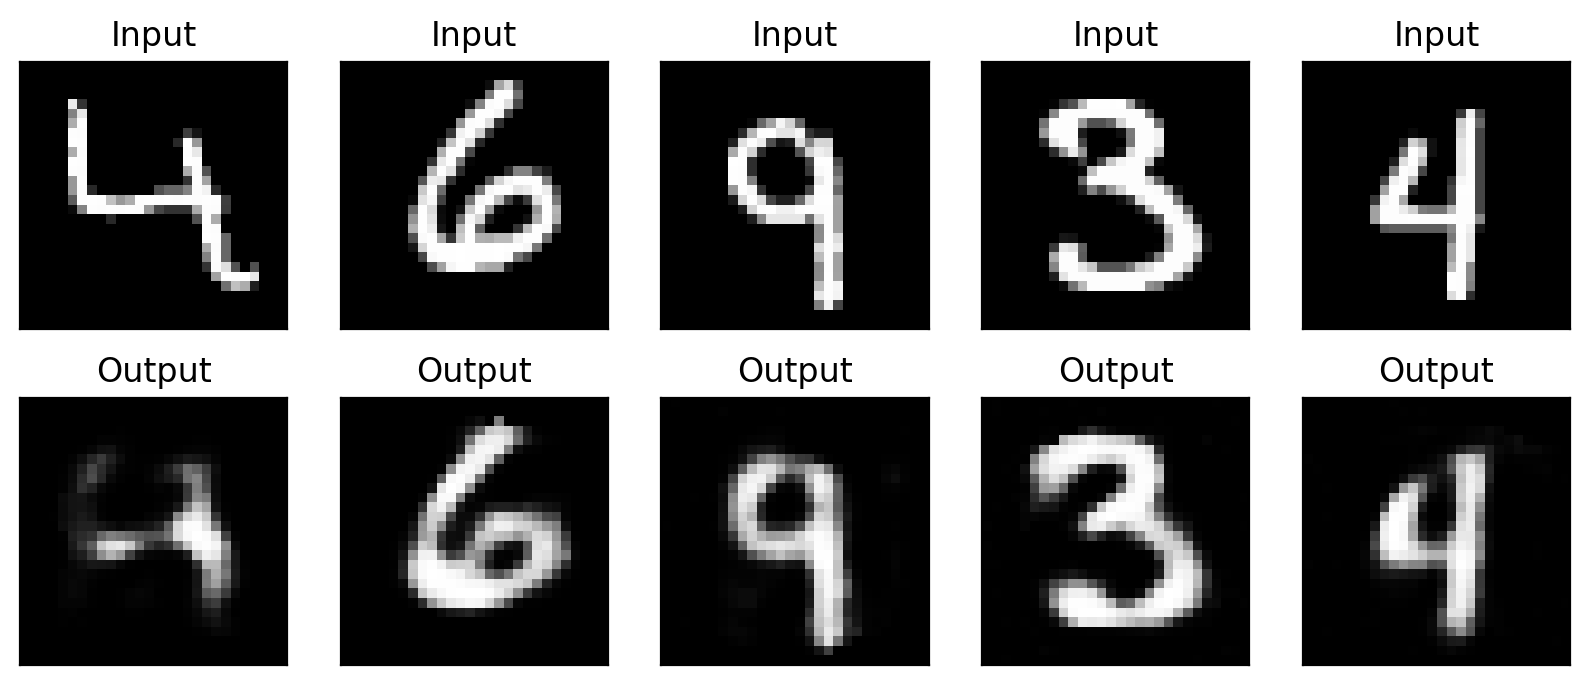

Hdim: 10


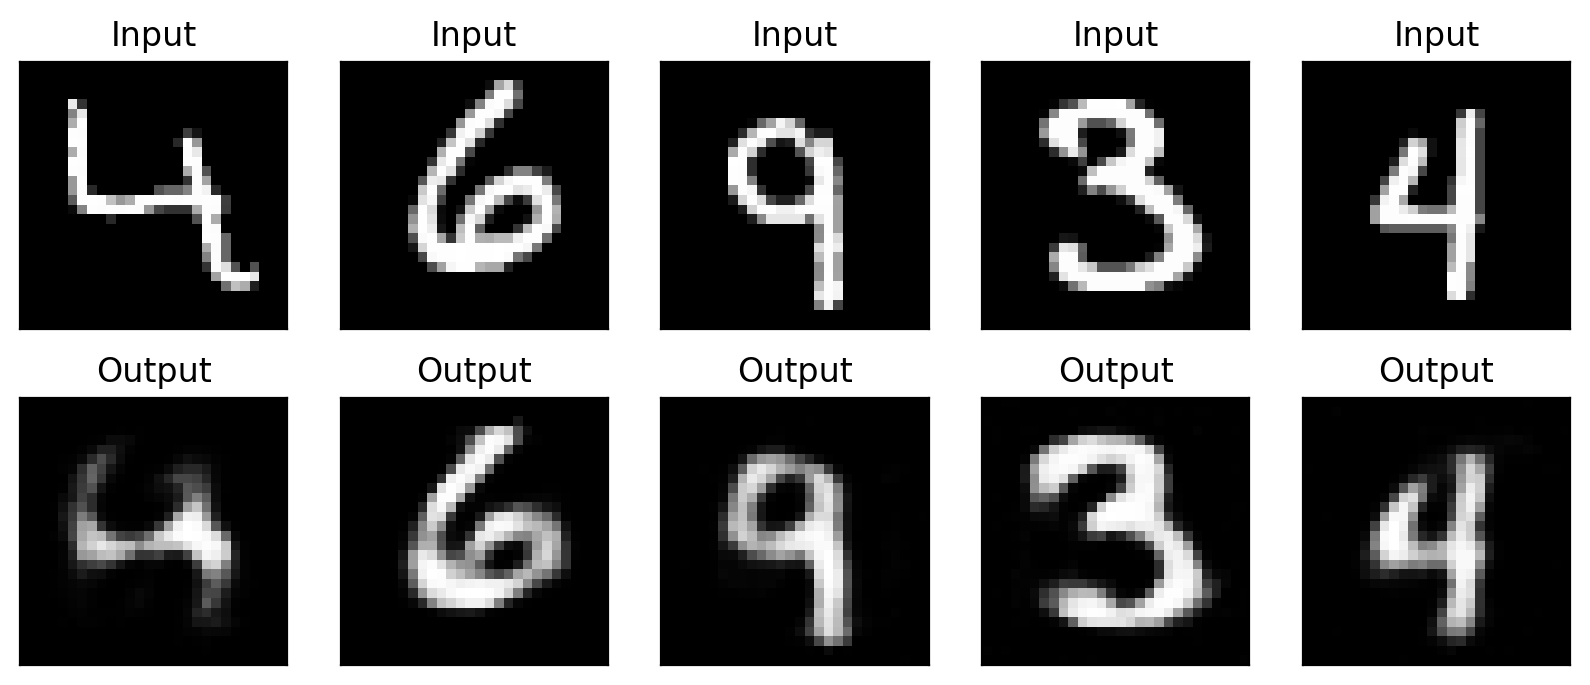

Hdim: 20


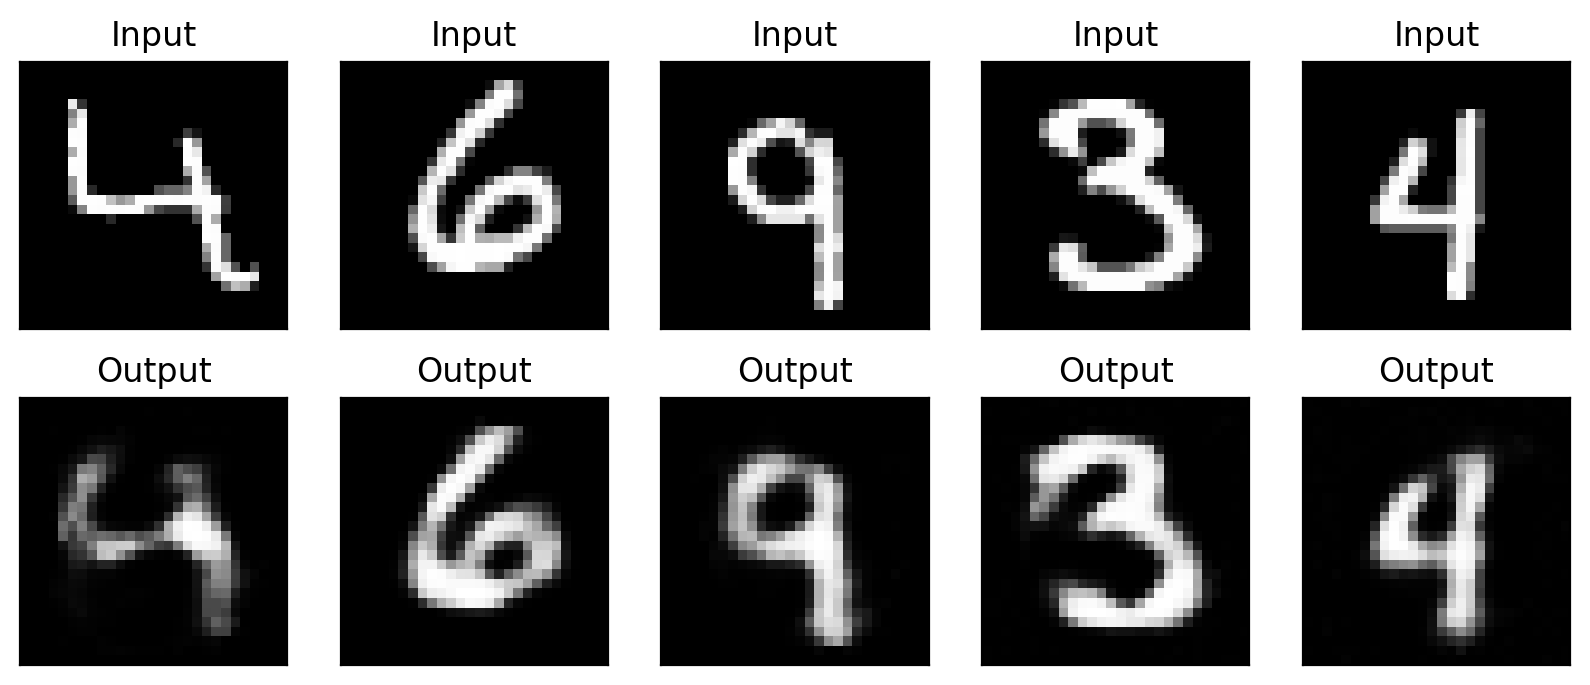

Hdim: 50


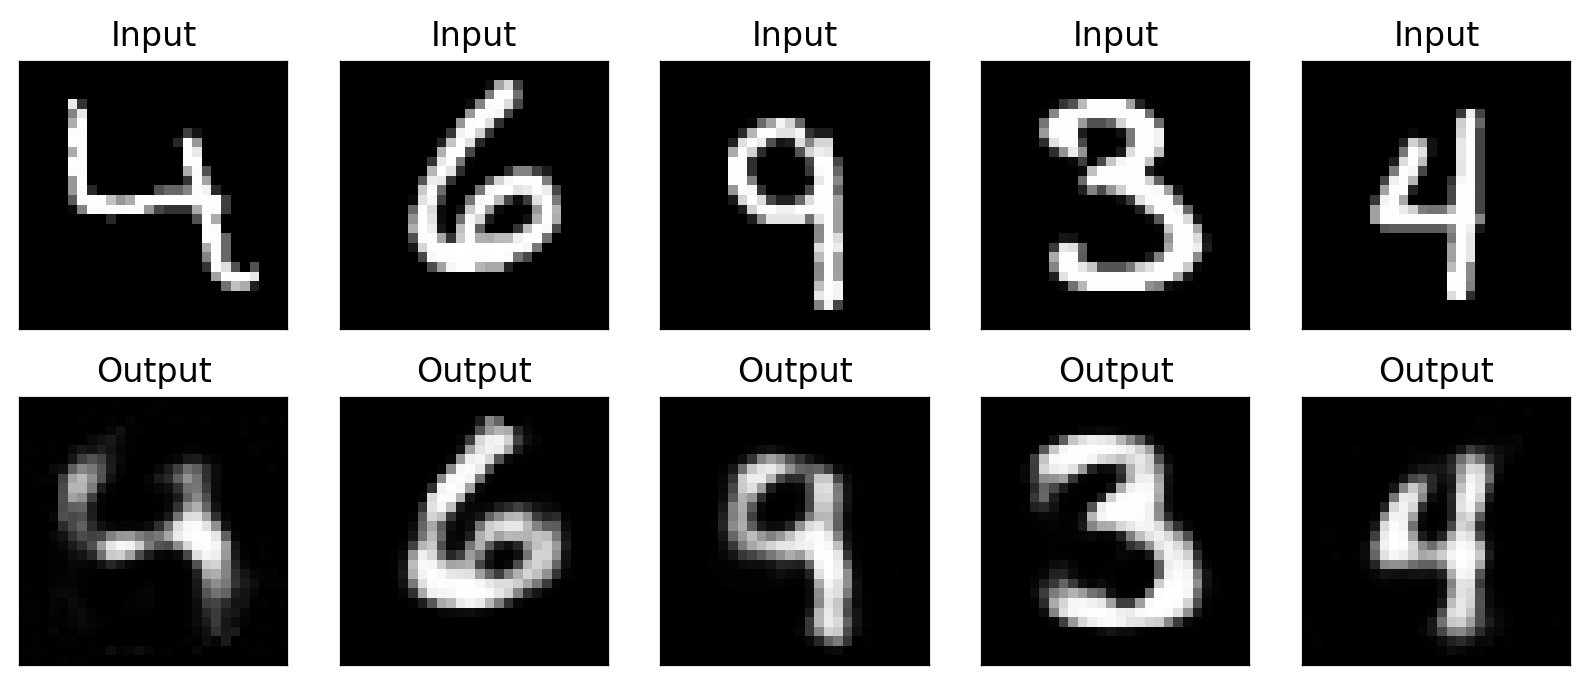

Hdim: 100


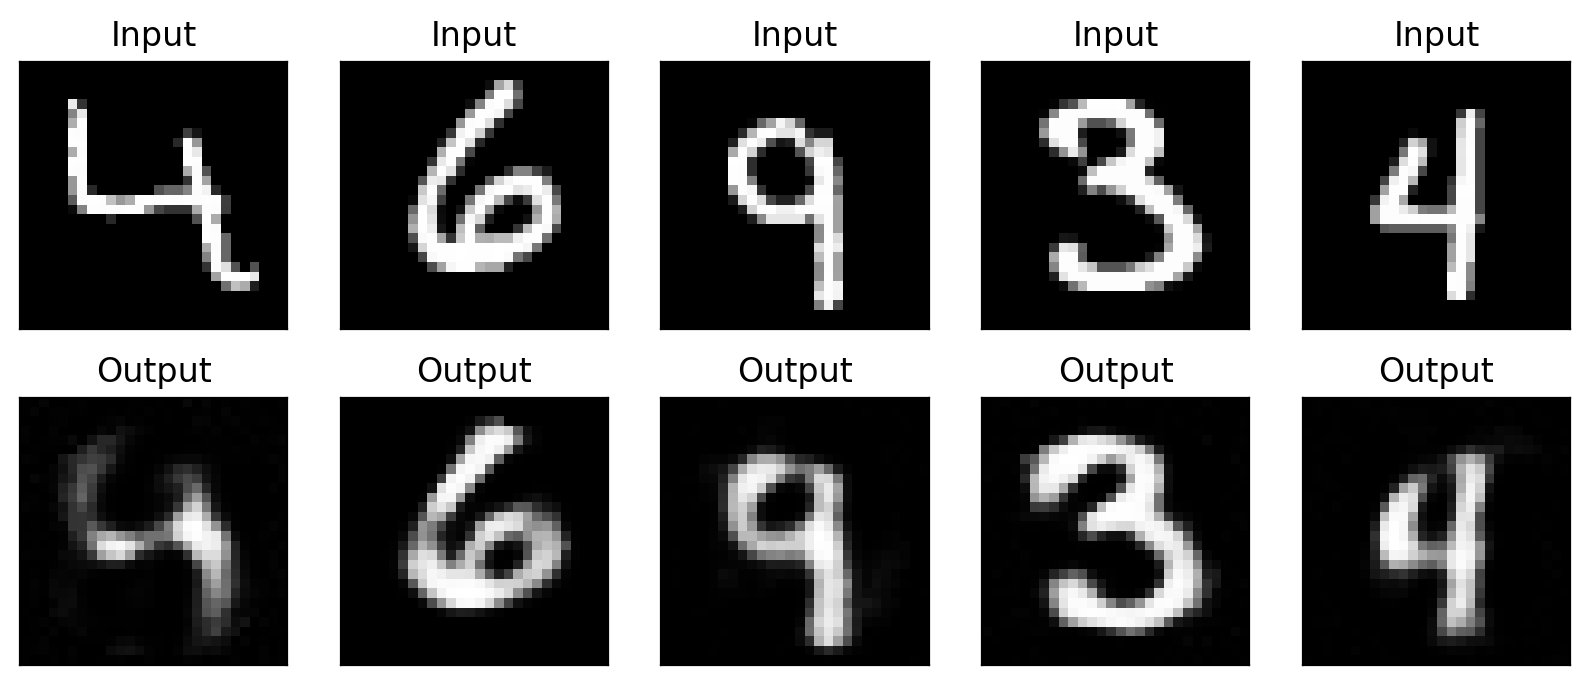

{'Hdim': [2, 10, 20, 50, 100], 'Test_loss': [0.2331227895617485, 0.017902558809146284, 0.01745604144409299]}


In [79]:
# Hidden Dimension

Loss_hdim = []
hdim_ = [2, 10, 20, 50, 100]
plot = False
verbose = False
# Complete code here
# Model Initialization
for hdim in [2, 10, 20, 50, 100]:
  print("Hdim:", hdim)
  AE = AElin(hdim=20).to(device)

  # Validation using MSE Loss function
  lossAE = nn.MSELoss() # Complete code here

  # Using an Adam Optimizer
  optimizer =  torch.optim.Adam(AE.parameters(), lr=0.01) # Complete code here

  #def AE_train(model, criterion, optimizer, epochs=30, plot = True,verbose=False, freq=10):
  train_losses, test_losses = AE_train(AE, lossAE, optimizer, epochs=2, plot=plot, verbose=verbose, freq=1000) # Complete code here

  Loss_hdim.append(test_losses)

  if plot:
    plot_result(AE)
    plotLatentScatter(AE.encoder_function, classes=[0,1,2,3,4,5,6,7,8,9])
    plotLatentScatter(AE.encoder_function, classes=[0,1])

  plot_result(AE)


print({"Hdim": hdim_, "Test_loss": test_losses})

In [ ]:
# Learning Rates

... # Complete code here

# 4 Use the AE as a denoising model

We will see in this section how we can use the a AutoEncoder a denoising model. Compare the performance of an excellent model and a decent model.

In [ ]:
AE = ... # Complete code here
optimizer = ... # Complete code here
AE_train( ... ) # Complete code here

images = first_batch_images[:1]
sigmas = [1e-2,2e-2, 5e-2, 1e-1,3e-1, 5e-1]
plt.figure(figsize=(8, 4))
for k, sigma in enumerate(sigmas):
    plt.subplot(3,len(sigmas),  k+1)
    if k==0:
        plt.ylabel('Original', fontsize=14)
    plt.imshow(images.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    noise = torch.randn(1, 1, 28, 28) * sigma
    plt.subplot(3, len(sigmas), k+1+len(sigmas))
    if k == 0:
        plt.ylabel('Noisy', fontsize=14)
    plt.imshow((noise+images).cpu().numpy().reshape(28, 28), cmap='gray')
    plt.title(f'noise: {sigma:.0e}')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3, len(sigmas), k+1+2*len(sigmas))
    if k == 0:
        plt.ylabel('Reconstructed', fontsize=14)
    plt.imshow(AE((images+noise).to(device)).cpu().detach().numpy().reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


In [ ]:
AE = ... # Complete code here
optimizer = ... # Complete code here
AE_train( ... ) # Complete code here

images = first_batch_images[:1]
sigmas = [1e-2,2e-2, 5e-2, 1e-1,3e-1, 5e-1]
plt.figure(figsize=(8, 4))
for k, sigma in enumerate(sigmas):

    plt.subplot(3,len(sigmas),  k+1)
    if k==0:
        plt.ylabel('Original', fontsize=14)
    plt.imshow(images.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])

    noise = torch.randn(1, 1, 28, 28) * sigma
    plt.subplot(3, len(sigmas), k+1+len(sigmas))
    if k == 0:
        plt.ylabel('Noisy', fontsize=14)
    plt.imshow((noise+images).cpu().numpy().reshape(28, 28), cmap='gray')
    plt.title(f'noise: {sigma:.0e}')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, len(sigmas), k+1+2*len(sigmas))
    if k == 0:
        plt.ylabel('Reconstructed', fontsize=14)
    plt.imshow(AE((images+noise).to(device)).cpu().detach().numpy().reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


# 5 Anomaly detection

Autoencoders can learn to represent the data in a latent representation space and to reconstruct the data from this compressed representation. One possible application of AE is Anomaly detection. The method is simple:
- if you encode and decode an image similar to the training data, the reconstruction loss should be low, while
- if you do the same with an image that differs from the training set, the loss should be higher.

We will use a strong model:

In [ ]:
AE = ... # Complete code here
optimizer = ... # Complete code here
AE_train( ... ); # Complete code here


To test compare data dstribution we can compare:
- the loss on the training data
- the loss on the training with different anomalies
    - Transpositions
    - Artifacts
    - Mixing

In [ ]:
def make_anomaly(input_data, mode='transpose'):
    '''make_anomaly
    Detect anomalies in the input data using the model
    Input:
        - input_data: the input data
        - mode: the mode for the anomaly detection among ['transpose', 'artifacts', 'mixing']
    Output:
        - anomalies: the pertubed images
    '''
    if mode == 'transpose':
        anomalies = input_data.clone()
        anomalies = anomalies.permute(0, 1, 3, 2)

    elif mode == 'artifacts':
        anomalies = input_data.clone()
        anomalies[:, :, 10:20, 10:20] = 1
    elif mode == 'mixing':
        anomalies = input_data.clone()
        anomalies[:, :, 10:15, 10:15] = input_data[:, :, 15:20, 15:20]
        anomalies[:, :, 15:20, 15:20] = input_data[:, :, 10:15, 10:15]
        anomalies[:, :, 10:15, 15:20] = input_data[:, :, 15:20, 10:15]
        anomalies[:, :, 15:20, 10:15] = input_data[:, :, 10:15, 15:20]
    return anomalies

In [ ]:
anomalies = make_anomaly(first_batch_images, mode='mixing')
recons = AE(first_batch_images.to(device))
recons_a = AE(anomalies.to(device))

plt.figure(figsize=(8, 5))
for i in range(5):
    plt.subplot(4, 5, i+1)
    image = first_batch_images[i].cpu().numpy().reshape(28, 28)
    if i == 0:
        plt.ylabel('Original', fontsize=14)
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4, 5, i+6)
    recon = recons[i].cpu().detach().numpy().reshape(28, 28)
    if i == 0:
        plt.ylabel('Recons', fontsize=14)
    plt.title(f'MSE: {np.linalg.norm(image - recon):.2f}', fontsize=14)
    plt.imshow(recon, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4, 5, i+11)
    anomaly = anomalies[i].detach().numpy().reshape(28, 28)
    if i == 0:
        plt.ylabel('Anomaly', fontsize=14)
    plt.imshow(anomaly, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4, 5, i+16)
    recon = recons_a[i].cpu().detach().numpy().reshape(28, 28)
    if i == 0:
        plt.ylabel('Recons', fontsize=14)
    plt.title(f'MSE: {np.linalg.norm(anomaly - recon):.2f}', fontsize=14)
    plt.imshow(recon, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

**TODO**:
- code a function that compute these two histograms and plot these
- check if the histogram differs for the different type of anomalies

In [ ]:
def detect_anomalies(model,loader, mode='transpose'):
    '''detect_anomalies
    Plot the histogram of the MSE of the anomalies on the test  set
    Input:
        - model: the trained model
        - mode: the mode for the anomaly detection among ['transpose', 'artifacts', 'mixing']
    Output:
        - None
    '''
    ... # Complete code here

In [ ]:
detect_anomalies(AE, train_loader, mode='transpose')
detect_anomalies(AE, train_loader, mode='artifacts')
detect_anomalies(AE, train_loader, mode='mixing')


# 6 Full connected autoencoder

We can increase the depth of the AE:
- the encoder is composed of a first linear transformation, followed by a non-linearity (ReLU) and a second linear transformation.
- the decoder performs the symmetric operations.

As dimensions we can consider as a first choice : 784 ==> 256 ==> $h_{dim}=2$ ==> 256 ==> 784.

**TODO**
- Write the class for such AE and test with the basic configuration (see above) first with $h_{dim}=2$, then with an higher  $h_{dim}<784$.

In [ ]:
class SimpleAE(nn.Module):
    def __init__(self,hdim1=256,hdim2=2):
        super().__init__()
        ... # Complete code here

    def encoder_function(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.reshape(x.size(0), 1, 28, 28)
        return decoded

In [ ]:
SAE = ... # Complete code here
optimizer = ... # Complete code here
_ = AE_train( ... ) # Complete code here
plot_result(SAE)
plotLatentScatter(SAE.encoder_function, classes=[0,1,2,3,4,5,6,7,8,9])
plotLatentScatter(SAE.encoder_function, classes=[0,1,2,3,4,5,6,7,8,9])

In [ ]:
SAE = ... # Complete code here
optimizer = ... # Complete code here
_ = AE_train( ... ) # Complete code here
plot_result(SAE)

Test the denoising and anomaly detection.

In [ ]:
images = first_batch_images[:1]
sigmas = [1e-2,2e-2, 5e-2, 1e-1,3e-1, 5e-1]
plt.figure(figsize=(8, 4))
for k, sigma in enumerate(sigmas):

    plt.subplot(3,len(sigmas),  k+1)
    if k==0:
        plt.ylabel('Original', fontsize=14)
    plt.imshow(images.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])

    noise = torch.randn(1, 1, 28, 28) * sigma
    plt.subplot(3, len(sigmas), k+1+len(sigmas))
    if k == 0:
        plt.ylabel('Noisy', fontsize=14)
    plt.imshow((noise+images).cpu().numpy().reshape(28, 28), cmap='gray')
    plt.title(f'noise: {sigma:.0e}')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, len(sigmas), k+1+2*len(sigmas))
    if k == 0:
        plt.ylabel('Reconstructed', fontsize=14)
    plt.imshow(SAE((images+noise).to(device)).cpu().detach().numpy().reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
detect_anomalies(SAE, train_loader, mode='transpose')
detect_anomalies(SAE, train_loader, mode='artifacts')
detect_anomalies(SAE, train_loader, mode='mixing')


# 7 Convolutional Autoencoder

**TODO**:
Implement a CNN Autoencoder with the following architecture:
- Encoder:
    - Conv2d(1, 16, kernel_size=3, stride=2, padding=1) ==> ReLU ==> Conv2d(16, 32, kernel_size=3, stride=2, padding=1) ==> ReLU ==> Conv2d(32, $h_{dim}$, kernel_size=7)
- Decoder:
    - ConvTranspose2d($h_{dim}$, 32, kernel_size=7) ==> ReLU ==> ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1) ==> ReLU ==> ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1) ==> Sigmoid

In [ ]:
class ConvAE(nn.Module):
    def __init__(self, hdim=2):
        super().__init__()
        ... # Complete code here

    def encoder_function(self, x):
        return self.encoder(x)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
CAE = ConvAE().to(device)
print_nparameters(CAE)
plot_result(CAE)


In [ ]:
CAE =  ... # Complete code here
optimizer = ... # Complete code here
_ = AE_train( ... ) # Complete code here
plot_result(CAE)
plotLatentScatter(CAE.encoder_function, classes=[0,1,2,3,4,5,6,7,8,9])
plotLatentScatter(CAE.encoder_function, classes=[0,1])

In [ ]:
images = first_batch_images[:1]
sigmas = [1e-2,2e-2, 5e-2, 1e-1,3e-1, 5e-1]
plt.figure(figsize=(8, 4))
for k, sigma in enumerate(sigmas):

    plt.subplot(3,len(sigmas),  k+1)
    if k==0:
        plt.ylabel('Original', fontsize=14)
    plt.imshow(images.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])

    noise = torch.randn(1, 1, 28, 28) * sigma
    plt.subplot(3, len(sigmas), k+1+len(sigmas))
    if k == 0:
        plt.ylabel('Noisy', fontsize=14)
    plt.imshow((noise+images).cpu().numpy().reshape(28, 28), cmap='gray')
    plt.title(f'noise: {sigma:.0e}')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, len(sigmas), k+1+2*len(sigmas))
    if k == 0:
        plt.ylabel('Reconstructed', fontsize=14)
    plt.imshow(CAE((images+noise).to(device)).cpu().detach().numpy().reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
detect_anomalies(CAE, train_loader, mode='transpose')
detect_anomalies(CAE, train_loader, mode='artifacts')
detect_anomalies(CAE, train_loader, mode='mixing')